## Explore TF isoform expression data

TODO
- try taking just 2 or 3 samples in the same data point
- compare adult tissues in GTEx and development
- can we do some statistics???

In [1]:
import os
from itertools import combinations

import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd


import ccsblib
from ccsblib import ccsbplotlib as cplt

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_annotated_gencode_tfs,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones,
                          load_seq_comparison_data,
                          load_gtex_gencode,
                          load_developmental_tissue_expression_gencode)

In [2]:
tfs = load_annotated_gencode_tfs()

df_gtex, metadata_gtex, genes_gtex = load_gtex_gencode()

#TODO: move to data_loading
exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}
df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_gencode()

# TODO: move to data_loading
rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}
metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())
all_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values() for orf in tf.orfs}
alt_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values()
            for orf in tf.orfs
            if tf.has_MANE_select_isoform and not orf.is_MANE_select_transcript}
ref_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values()
            for orf in tf.orfs
            if tf.has_MANE_select_isoform and orf.is_MANE_select_transcript}

reading from cache
reading from cache
reading from cache


In [6]:
metadata_dev.shape

(313, 42)

In [7]:
metadata_gtex.shape

(2485, 49)

In [4]:
# compare GTEx and dev datasets
df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).value_counts().rename('# samples').value_counts().sort_index().to_frame()

,# samples
1,27
2,43
3,33
4,19
5,5


In [5]:
metadata_dev.groupby(['organism_part'])['dev_stage'].nunique().to_frame()

,dev_stage
organism_part,
forebrain,20
heart,19
hindbrain,19
kidney,17
liver,21
ovary,12
testis,19


In [31]:
df_gtex.columns.map(metadata_gtex['body_site']).value_counts().rename('# samples').to_frame()

,# samples
Lung,379
Thyroid,360
Colon - Transverse,206
Colon - Sigmoid,173
Adrenal Gland,161
Liver,138
Kidney - Cortex,36
Breast - Mammary Tissue,35
Whole Blood,33
Skin - Not Sun Exposed (Suprapubic),32


In [48]:
(means_gtex > 1).any(axis=1).value_counts()

True     3264
False     880
dtype: int64

In [ ]:
(means_gtex.loc[means_gtex.index.isin(alt_isos), :].sum(axis=1) >= 1).sum()

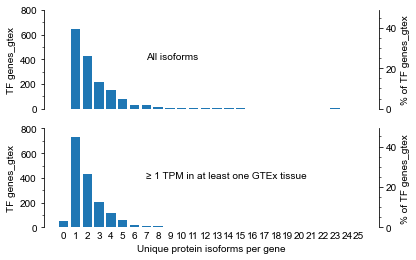

In [61]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=True)

n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).size()
x_max = n_iso.max()
xs = range(0, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[1].set_xticks(xs)
axs[1].set_xlabel('Unique protein isoforms per gene')
axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in at least one GTEx tissue')

def num2pct(y):
    return (y / n_iso.shape[0]) * 100

def pct2num(y):
    return (y / 100) * n_iso.shape[0]

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('TF genes_gtex')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('% of TF genes_gtex')
    pctax.set_yticks(range(0, 46, 5), minor=True)
fig.savefig('../../figures/n-isoforms-per-gene_by-1TPM-cutoff_hist.pdf',
            bbox_inches='tight')

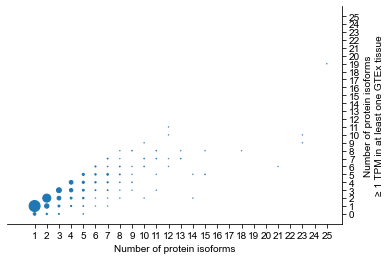

In [62]:
# plot 2D
n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).sum().rename('tpm').to_frame()
n_iso['n'] = (means_gtex > 1).any(axis=1).groupby(genes_gtex).size()
xy_max = n_iso['n'].max()
pos = [(x, y) for x in range(xy_max + 1) for y in range(xy_max + 1)]
vals = [((n_iso['n'] == x) & (n_iso['tpm'] == y)).sum() for x, y in pos]
fig, ax = plt.subplots(1, 1)
ax.scatter(x=[x for x, _y in pos],
           y=[y for _x, y in pos],
           s=[v * 0.2 for v in vals])
ax.set_xticks(range(1, 26))
ax.set_yticks(range(0, 26))
ax.set_xlabel('Number of protein isoforms')
ax.set_ylabel('Number of protein isoforms\n≥ 1 TPM in at least one GTEx tissue')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
for pos in ['top', 'left']:
    ax.spines[pos].set_visible(False)
fig.savefig('../../figures/n_isoforms-vs-n-gte1TPM_circle-plot.pdf',
            bbox_inches='tight')

In [7]:
# fraction of alternative isoforms
sum(hasattr(tf.orfs[0], 'is_MANE_select_transcript') for tf in tfs.values())

1585

In [ ]:
n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).sum()

In [19]:
means_gtex.loc[~means_gtex.index.isin(all_isos), :]

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
UID,,,,,,,,,,,,,,,,,,,,,
AC006213,0.892265,0.683811,0.889699,0.678744,0.724681,0.640086,0.980988,0.322795,0.389116,0.454024,...,0.629370,0.685099,0.645889,0.563841,0.563940,1.141533,1.081476,1.037433,0.832994,0.121650
TSHZ2-201,0.207888,0.342945,0.274793,0.002302,0.036515,0.000000,0.111042,0.002387,0.000000,0.000000,...,0.089868,0.068548,0.000000,0.000000,0.065778,0.000000,0.002431,0.028480,0.016416,0.005918
AC118549,3.582673,3.336869,3.426940,3.292830,3.484080,3.623147,3.878994,2.150420,2.306803,2.318305,...,3.529575,3.618398,3.151645,3.143918,2.839285,2.944304,3.833875,3.931468,3.490366,0.777627
AC008554,1.748720,1.480524,2.661524,1.600113,1.636796,1.476353,2.487543,0.910861,1.114902,1.433659,...,1.773451,1.737215,1.785191,1.835943,1.454453,1.790073,3.257224,2.128603,1.943189,0.586604
AC092072,2.253606,1.884177,2.039085,1.715308,1.861778,1.488062,2.423236,1.099927,1.516492,1.633582,...,2.028555,2.119856,2.363399,2.323229,1.783164,2.381552,2.573085,2.424715,2.271912,0.447487
MYC-206|MYC-207,4.765034,4.802835,3.695358,3.031495,3.502662,3.005516,4.218939,0.349904,0.484632,0.371736,...,5.789437,5.037060,3.416664,3.314451,3.493697,2.626950,2.995373,3.407007,4.307756,1.700966
NR1I2-203|NR1I2-206,0.020707,0.009469,0.026282,0.036299,0.013927,0.034189,0.013002,0.004794,0.009769,0.031116,...,0.038161,0.014437,1.972679,0.111571,0.030962,0.084344,0.044581,0.022359,0.020762,0.011566
AC073611,0.406562,0.039334,0.011565,0.039440,0.042054,0.043198,0.014083,0.191694,0.230967,0.235372,...,0.064124,0.057069,0.035753,0.037706,0.020157,0.951978,0.397725,0.083547,0.051633,0.016488
TEAD1-206|TEAD1-207,3.918744,3.690190,2.256134,3.292783,3.312753,3.451554,4.749619,2.171504,2.118140,2.268236,...,3.069135,3.309038,3.055821,2.056649,2.972772,2.753343,3.521874,4.123058,3.507186,0.030242


1515 out of 2262 (67%) alternative isoforms ≥ 1 TPM in at least one tissue
725 out of 2262 (32%) alternative isoforms ≥ 5 TPM in at least one tissue
1016 out of 1084 (94%) MANE select isoforms ≥ 1 TPM in at least one tissue
761 out of 1084 (70%) MANE select isoforms ≥ 5 TPM in at least one tissue


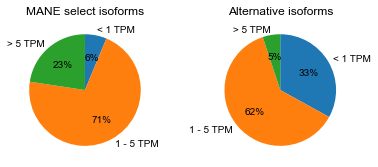

In [54]:
p = (means_gtex.loc[means_gtex.index.isin(alt_isos), :] >= 1).any(axis=1).sum()
n = means_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(alt_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(ref_isos), :] >= 1).any(axis=1).sum()
n = means_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(ref_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = means_gtex.max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../../figures/GTEx-max-expression_by-reference-vs-alternative_pie.pdf',
            bbox_inches='tight')

1408 out of 2262 (62%) alternative isoforms ≥ 1 TPM in at least one tissue
651 out of 2262 (29%) alternative isoforms ≥ 5 TPM in at least one tissue
976 out of 1084 (90%) MANE select isoforms ≥ 1 TPM in at least one tissue
717 out of 1084 (66%) MANE select isoforms ≥ 5 TPM in at least one tissue


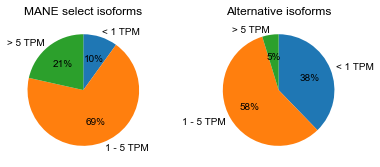

In [58]:
# Exlclude testis
cols = [c for c in means_gtex.columns if c != 'Testis']
p = (means_gtex.loc[means_gtex.index.isin(alt_isos), cols] >= 1).any(axis=1).sum()
n = means_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(alt_isos), cols] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(ref_isos), cols] >= 1).any(axis=1).sum()
n = means_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(ref_isos), cols] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = means_gtex.loc[:, cols].max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../../figures/GTEx-max-expression_by-reference-vs-alternative_no-testis_pie.pdf',
            bbox_inches='tight')

1879 out of 2262 (83%) alternative isoforms ≥ 1 TPM in at least one tissue/dev stage
1177 out of 2262 (52%) alternative isoforms ≥ 5 TPM in at least one tissue/dev stage
1044 out of 1084 (96%) MANE select isoforms ≥ 1 TPM in at least one tissue/dev stage
911 out of 1084 (84%) MANE select isoforms ≥ 5 TPM in at least one tissue/dev stage


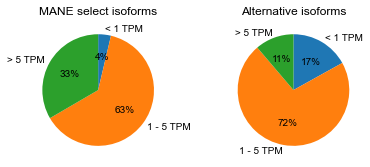

In [64]:
p = (means_dev.loc[means_dev.index.isin(alt_isos), :] >= 1).any(axis=1).sum()
n = means_dev.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue/dev stage')

p = (means_dev.loc[means_dev.index.isin(alt_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_dev.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue/dev stage')

p = (means_dev.loc[means_dev.index.isin(ref_isos), :] >= 1).any(axis=1).sum()
n = means_dev.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue/dev stage')

p = (means_dev.loc[means_dev.index.isin(ref_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_dev.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue/dev stage')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = means_dev.max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../../figures/developmental-max-expression_by-reference-vs-alternative_pie.pdf',
            bbox_inches='tight')

In [116]:
# TODO: move this cell
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

1523 out of 2094 (73%) alternative isoforms ≥ 1 TPM in at least one tissue
785 out of 2094 (37%) alternative isoforms ≥ 5 TPM in at least one tissue
1038 out of 1084 (96%) MANE select isoforms ≥ 1 TPM in at least one tissue
810 out of 1084 (75%) MANE select isoforms ≥ 5 TPM in at least one tissue


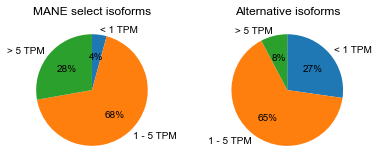

In [117]:
p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(alt_isos), :] >= 1).any(axis=1).sum()
n = means_gtex_downsample.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(alt_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex_downsample.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(ref_isos), :] >= 1).any(axis=1).sum()
n = means_gtex_downsample.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(ref_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex_downsample.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = means_gtex_downsample.max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../../figures/downsampled-GTEx-control-max-expression_by-reference-vs-alternative_pie.pdf',
            bbox_inches='tight')

In [50]:
# Apologies for the confusing code here
# getting the 3rd highest sample per isoform per tissue/dev timepoint

def third_highest(data):
    if data.shape[0] < 3:
        return np.nan
    return list(sorted(data, reverse=True))[2]

third_gtex = (df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
                     .apply(lambda x: x.apply(third_highest, axis=1)))
third_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
                     .apply(lambda x: x.apply(third_highest, axis=1)))

In [56]:
third_dev.notnull().sum(axis=1)

UID
AC006213.1-202_AC006213.1-203_AC006213.1-204_AC006213.1-205    57
AC008554.1-202                                                 57
AC008554.1-205                                                 57
AC008770.2-201                                                 57
AC008770.2-202                                                 57
                                                               ..
ZUP1-202                                                       57
ZXDA-201                                                       57
ZXDB-201                                                       57
ZXDC-201                                                       57
ZXDC-202                                                       57
Length: 4144, dtype: int64

1793 out of 2094 (86%) alternative isoforms ≥ 1 TPM in at least one tissue
1143 out of 2094 (55%) alternative isoforms ≥ 5 TPM in at least one tissue
1060 out of 1084 (98%) MANE select isoforms ≥ 1 TPM in at least one tissue
915 out of 1084 (84%) MANE select isoforms ≥ 5 TPM in at least one tissue


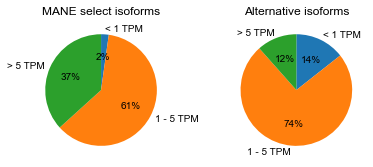

In [51]:
# try requiring at least two samples in the same datapoint to reach the expression threshold
p = (third_gtex.loc[third_gtex.index.isin(alt_isos), :] >= 1).any(axis=1).sum()
n = third_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

p = (third_gtex.loc[third_gtex.index.isin(alt_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = third_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

p = (third_gtex.loc[third_gtex.index.isin(ref_isos), :] >= 1).any(axis=1).sum()
n = third_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

p = (third_gtex.loc[third_gtex.index.isin(ref_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = third_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = third_gtex.max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../../figures/GTEx-max-third-highest-sample-expression_by-reference-vs-alternative_pie.pdf',
            bbox_inches='tight')

1378 out of 2094 (66%) alternative isoforms ≥ 1 TPM in at least one tissue
769 out of 2094 (37%) alternative isoforms ≥ 5 TPM in at least one tissue
979 out of 1084 (90%) MANE select isoforms ≥ 1 TPM in at least one tissue
807 out of 1084 (74%) MANE select isoforms ≥ 5 TPM in at least one tissue


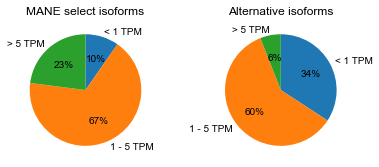

In [53]:
# try requiring at least two samples in the same datapoint to reach the expression threshold
p = (third_dev.loc[third_dev.index.isin(alt_isos), :] >= 1).any(axis=1).sum()
n = third_dev.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

p = (third_dev.loc[third_dev.index.isin(alt_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = third_dev.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

p = (third_dev.loc[third_dev.index.isin(ref_isos), :] >= 1).any(axis=1).sum()
n = third_dev.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

p = (third_dev.loc[third_dev.index.isin(ref_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = third_dev.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = third_dev.max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../../figures/developmental-max-third-highest-sample-expression_by-reference-vs-alternative_pie.pdf',
            bbox_inches='tight')

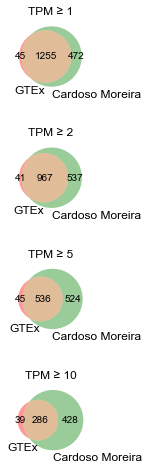

In [137]:
# overlap between tissue and development
# need to deal with adult tissues in development data
from matplotlib_venn import venn2, venn3
tpm_thresholds = [1, 2, 5, 10]
fig, axs = plt.subplots(len(tpm_thresholds), 1)
fig.set_size_inches(w=2, h=2 * len(tpm_thresholds))
for tpm_threshold, ax in zip(tpm_thresholds, axs):
    a = set(means_gtex[(means_gtex.max(axis=1) >= np.log2(tpm_threshold + 1)) &
                    means_gtex.index.isin(alt_isos)].index.values)
    b = set(means_dev[(means_dev.max(axis=1) >= np.log2(tpm_threshold + 1)) &
                    means_dev.index.isin(alt_isos)].index.values)
    venn2([a, b], set_labels=['GTEx', 'Cardoso Moreira'], ax=ax)
    ax.set_title(f'TPM ≥ {tpm_threshold}')
plt.subplots_adjust(hspace=0.7)
fig.savefig('../../figures/expressed-alt-isoform-overlap-by-TPM-threshold_Venn.pdf',
            bbox_inches='tight')

In [140]:
metadata_dev['dev_stage'].value_counts()

08             24
11             20
07             20
young adult    18
13             18
10             18
infant         18
16             17
19             16
04             16
09             16
neonate        16
adolescent     14
05             13
12             13
06             13
18             11
toddler        11
child           7
adult           7
elderly         7
Name: dev_stage, dtype: int64

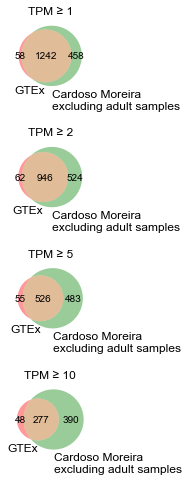

In [146]:
# remove adult tissues in development data
to_exclude = {'young adult', 'adult', 'elderly'}
df_dev.loc[:, df_dev.columns.map(~metadata_dev['dev_stage'].isin(to_exclude))]
means_dev_restricted = (df_dev.loc[:, df_dev.columns.map(~metadata_dev['dev_stage'].isin(to_exclude))].groupby(df_dev.loc[:, df_dev.columns.map(~metadata_dev['dev_stage'].isin(to_exclude))].columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

tpm_thresholds = [1, 2, 5, 10]
fig, axs = plt.subplots(len(tpm_thresholds), 1)
fig.set_size_inches(w=2, h=2 * len(tpm_thresholds))
for tpm_threshold, ax in zip(tpm_thresholds, axs):
    a = set(means_gtex[(means_gtex.max(axis=1) >= np.log2(tpm_threshold + 1)) &
                    means_gtex.index.isin(alt_isos)].index.values)
    b = set(means_dev_restricted[(means_dev_restricted.max(axis=1) >= np.log2(tpm_threshold + 1)) &
                    means_dev_restricted.index.isin(alt_isos)].index.values)
    venn2([a, b], set_labels=['GTEx', 'Cardoso Moreira\nexcluding adult samples'], ax=ax)
    ax.set_title(f'TPM ≥ {tpm_threshold}')
plt.subplots_adjust(hspace=0.7)
fig.savefig('../../figures/expressed-alt-isoform-overlap-restricted-by-TPM-threshold_Venn.pdf',
            bbox_inches='tight')

In [70]:
(df_gtex.shape, df_dev.shape)

((4144, 2485), (4144, 313))

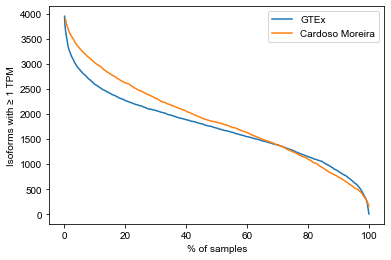

In [75]:
n_samples_gtex = df_gtex.shape[1]
n_samples_gt1_gtex = (df_gtex >= 1).sum(axis=1)
n_samples_dev = df_dev.shape[1]
n_samples_gt1_dev = (df_dev >= 1).sum(axis=1)

fig, ax = plt.subplots(1, 1)
ax.plot([i / n_samples_gtex * 100 for i in range(1, n_samples_gtex + 1)],
        [(n_samples_gt1_gtex >= i).sum() for i in range(1, n_samples_gtex + 1)],
        label='GTEx')
ax.plot([i / n_samples_dev * 100 for i in range(1, n_samples_dev + 1)],
        [(n_samples_gt1_dev >= i).sum() for i in range(1, n_samples_dev + 1)],
        label='Cardoso Moreira')
ax.legend()
ax.set_ylabel('Isoforms with ≥ 1 TPM')
ax.set_xlabel('% of samples')
fig.savefig('../../figures/n-isoforms-vs-pct-samples_GTEx-vs-development_line-plot.pdf',
            bbox_inches='tight')

In [68]:
# is this difference just individual level variation?
(df_gtex.max(axis=1) > 1).value_counts()

True     3947
False     197
dtype: int64

In [ ]:
# is it possible to partition tissue and developmental stage specific isoforms?
# can I do this within the cardoso morosia data?

In [69]:
(df_dev.max(axis=1) > 1).value_counts()

True     3893
False     251
dtype: int64

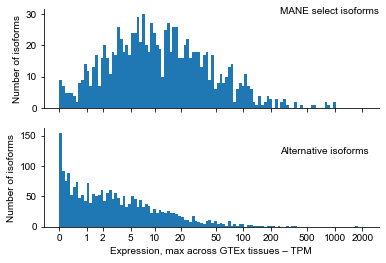

In [76]:
# plot distribution of isoforms by TPM
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins = 110
x_max = 11
axs[1].hist(means_gtex.max(axis=1)[means_gtex.index.isin(alt_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].hist(means_gtex.max(axis=1)[means_gtex.index.isin(ref_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].text(x=8, y=30, s='MANE select isoforms')
axs[1].text(x=8, y=120, s='Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
axs[1].set_xlabel('Expression, max across GTEx tissues – TPM')
x_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
axs[1].set_xticks([np.log2(x + 1) for x in x_ticks])
axs[1].set_xticklabels(x_ticks)
fig.savefig('../../figures/expression_GTEX_GENCODE-isoforms_by-reference-vs-alternative.pdf',
            bbox_inches='tight')

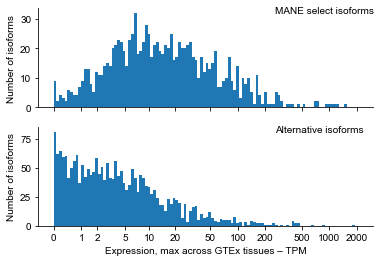

In [119]:
# plot distribution of isoforms by TPM
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins = 110
x_max = 11
axs[1].hist(means_gtex_downsample.max(axis=1)[means_gtex_downsample.index.isin(alt_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].hist(means_gtex_downsample.max(axis=1)[means_gtex_downsample.index.isin(ref_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].text(x=8, y=axs[0].get_ylim()[1] * 0.95, s='MANE select isoforms')
axs[1].text(x=8, y=axs[1].get_ylim()[1] * 0.95, s='Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
axs[1].set_xlabel('Expression, max across GTEx tissues – TPM')
x_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
axs[1].set_xticks([np.log2(x + 1) for x in x_ticks])
axs[1].set_xticklabels(x_ticks)
fig.savefig('../../figures/expression_downsampled-GTEX-control_GENCODE-isoforms_by-reference-vs-alternative.pdf',
            bbox_inches='tight')

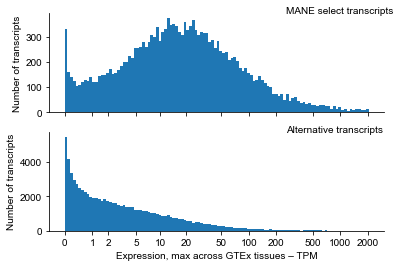

In [53]:
# include all genes

from data_loading import DATA_DIR


def load_gtex_gencode_all_genes():
    """
    NOTE: not summing up the transcripts with identical CDS
    
    """
    df = pd.read_csv(
        DATA_DIR / "processed/expression_2022-09-01/transcript.GTEx-GC30_Isoforms.txt",
        sep="\t",
    )
    metadata = pd.read_csv(
        DATA_DIR / "processed/gtex_2022/GTEx_SRARunTable.txt", sep="\t"
    )
    if metadata["Run"].duplicated().any():
        raise UserWarning("Unexpected duplicates")
    metadata = metadata.set_index("Run")
    df = df.set_index("UID")
    df = (df + 1.0).apply(np.log2)

    def extract_ensembl_gene_id(s):
        return s.split("|")[1].split(".")[0]

    genes = pd.Series(
        index=df.index,
        data=df.index.map(extract_ensembl_gene_id).values,
    )
    df.index = df.index.map(lambda x: x.split('|')[0].split('.')[0])
    genes.index = genes.index.map(lambda x: x.split('|')[0].split('.')[0])
    return df, metadata, genes

df_gtex_all, metadata_gtex_all, genes_gtex_all = load_gtex_gencode_all_genes()
df_gtex_all = df_gtex_all.loc[:, ~df_gtex_all.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex_all = metadata_gtex_all.loc[~metadata_gtex_all['body_site'].isin(exclusion_list_gtex), :]
means_gtex_all = df_gtex_all.groupby(df_gtex_all.columns.map(metadata_gtex_all['body_site']), axis=1).mean()

path_MANE_select=DATA_DIR / "external/MANE.GRCh38.v0.95.summary.txt"
mane = pd.read_csv(path_MANE_select, sep="\t")
mane_select = set(
    mane.loc[mane["MANE_status"] == "MANE Select", "Ensembl_nuc"]
    .str.slice(0, 15)
    .values
)

fig, axs = plt.subplots(2, 1, sharex=True)
n_bins = 110
x_max = 11
axs[0].hist(means_gtex_all.max(axis=1)[means_gtex_all.index.isin(mane_select)],
            bins=n_bins,
            range=(0, x_max))
axs[1].hist(means_gtex_all.max(axis=1)[~means_gtex_all.index.isin(mane_select)],
            bins=n_bins,
            range=(0, x_max))
axs[0].text(x=8, y=axs[0].get_ylim()[1], s='MANE select transcripts')
axs[1].text(x=8, y=axs[1].get_ylim()[1], s='Alternative transcripts')
for ax in axs:
    ax.set_ylabel('Number of transcripts')
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
axs[1].set_xlabel('Expression, max across GTEx tissues – TPM')
x_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
axs[1].set_xticks([np.log2(x + 1) for x in x_ticks])
axs[1].set_xticklabels(x_ticks)
fig.savefig('../../figures/expression_GTEX_GENCODE-transcripts_by-reference-vs-alternative-for-all-genes-not-just-TFs.pdf',
            bbox_inches='tight')

In [51]:
means_gtex_all.max(axis=1)[~means_gtex_all.index.isin(mane_select)]

UID
ENST00000641515.2     0.011930
ENST00000335137.4     0.019545
ENST00000426406.3     0.470428
ENST00000332831.4     0.470428
ENST00000420190.6     2.024814
                       ...    
ENST00000361335.1    15.180062
ENST00000361381.2    15.699318
ENST00000361567.2    13.067829
ENST00000361681.2    13.723324
ENST00000361789.2    15.079208
Length: 99731, dtype: float64

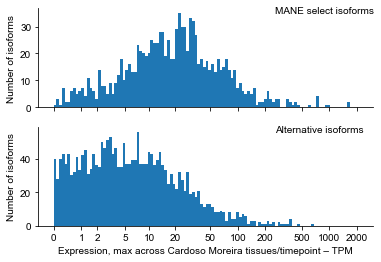

In [41]:
# plot distribution of isoforms by TPM
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins = 110
x_max = 11
axs[1].hist(means_dev.max(axis=1)[means_dev.index.isin(alt_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].hist(means_dev.max(axis=1)[means_dev.index.isin(ref_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].text(x=8, y=axs[0].get_ylim()[1] * 0.95, s='MANE select isoforms')
axs[1].text(x=8, y=axs[1].get_ylim()[1] * 0.95, s='Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
axs[1].set_xlabel('Expression, max across Cardoso Moreira tissues/timepoint – TPM')
x_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
axs[1].set_xticks([np.log2(x + 1) for x in x_ticks])
axs[1].set_xticklabels(x_ticks)
fig.savefig('../../figures/expression_development_GENCODE-isoforms_by-reference-vs-alternative.pdf',
            bbox_inches='tight')

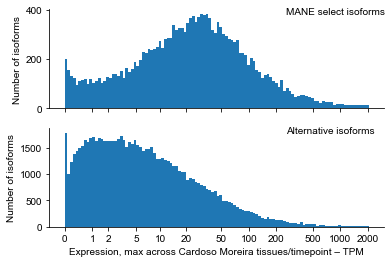

In [54]:
def load_developmental_tissue_expression_gencode_all_genes():
    """
    Cardoso-Moreira et al. Nature


    """
    metadata = pd.read_csv(DATA_DIR / "processed/Cardoso-Moreira_et_al/metadata.txt")
    df = pd.read_csv(
        DATA_DIR
        / "processed/expression_2022-09-01/transcript.Cardoso-Moreira-et-al-Nature-2019-GC30_Isoforms.txt",
        sep="\t",
    )
    if metadata["Run"].duplicated().any():
        raise UserWarning("Unexpected duplicates")
    metadata = metadata.set_index("Run")
    df = df.set_index("UID")
    df = (df + 1.0).apply(np.log2)

    def extract_ensembl_gene_id(s):
        return s.split("|")[1].split(".")[0]

    genes = pd.Series(
        index=df.index,
        data=df.index.map(extract_ensembl_gene_id).values,
    )
   
    genes = genes[~genes.index.duplicated(keep="first")]

    # the file has ERR2598062.fastq.gz instead of ERR2598062
    df.columns = df.columns.str.slice(0, -len(".fastq.gz"))

    if not df.columns.isin(metadata.index).all():
        raise UserWarning("Missing metadata")
    metadata = metadata.loc[metadata.index.isin(df.columns), :]
    df.index = df.index.map(lambda x: x.split('|')[0].split('.')[0])
    genes.index = genes.index.map(lambda x: x.split('|')[0].split('.')[0])
    return df, metadata, genes


df_dev_all, metadata_dev_all, genes_dev_all = load_developmental_tissue_expression_gencode_all_genes()
metadata_dev_all['dev_stage'] = metadata_dev_all['Developmental_Stage'].map(rename_dev_stage)
means_dev_all = (df_dev_all.groupby(df_dev_all.columns.map(metadata_dev_all['organism_part'] + ' ' + metadata_dev_all['dev_stage']), axis=1)
           .mean())

fig, axs = plt.subplots(2, 1, sharex=True)
n_bins = 110
x_max = 11
axs[0].hist(means_dev_all.max(axis=1)[means_dev_all.index.isin(mane_select)],
            bins=n_bins,
            range=(0, x_max))
axs[1].hist(means_dev_all.max(axis=1)[~means_dev_all.index.isin(mane_select)],
            bins=n_bins,
            range=(0, x_max))
axs[0].text(x=8, y=axs[0].get_ylim()[1] * 0.95, s='MANE select isoforms')
axs[1].text(x=8, y=axs[1].get_ylim()[1] * 0.95, s='Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
axs[1].set_xlabel('Expression, max across Cardoso Moreira tissues/timepoint – TPM')
x_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
axs[1].set_xticks([np.log2(x + 1) for x in x_ticks])
axs[1].set_xticklabels(x_ticks)
fig.savefig('../../figures/expression_development_GENCODE-transcripts_by-reference-vs-alternative-for-all-genes-not-just-TFs.pdf',
            bbox_inches='tight')

In [59]:
(
    means_gtex.loc[means_gtex.index.isin(ref_isos)].max(axis=1).mean(),
    means_dev.loc[means_dev.index.isin(ref_isos)].max(axis=1).mean(),
    means_gtex_all.loc[means_gtex_all.index.isin(mane_select)].max(axis=1).mean(),
    means_dev_all.loc[means_dev_all.index.isin(mane_select)].max(axis=1).mean(),
)

(3.5190036879087487, 4.313855749314403, 4.245403084218637, 4.5703124658168415)

In [70]:
# GAPDH and actin
(
    means_gtex_all.groupby(genes_gtex_all).sum().max(axis=1)['ENSG00000111640'],
    means_dev_all.groupby(genes_dev_all).sum().max(axis=1)['ENSG00000111640'],
    means_gtex_all.groupby(genes_gtex_all).sum().max(axis=1)['ENSG00000075624'],
    means_dev_all.groupby(genes_dev_all).sum().max(axis=1)['ENSG00000075624']

    )

(35.58638346527894, 42.63682806797509, 56.03674976423328, 57.430600990641494)

In [5]:
# number of isoforms vs gene expression, publications, and exons 
tpm_per_gene = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .sum()
                .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
                .mean())
gn = tpm_per_gene.max(axis=1).rename('TPM - gene-level, max across GTEx tissues').to_frame()
gn['n_isoforms'] = gn.index.map(genes_gtex.value_counts())

In [6]:
from ccsblib.huri import load_number_publications_per_gene, load_id_map

n_pub = load_number_publications_per_gene().to_frame().reset_index()
ensembl_to_hgnc = (load_id_map('ensembl_gene_id', 'hgnc_symbol')
                    .drop_duplicates('ensembl_gene_id')
                    .set_index('ensembl_gene_id')
                    ['hgnc_symbol'])
n_pub['hgnc_symbol'] = n_pub['ensembl_gene_id'].map(lambda x: ensembl_to_hgnc.get(x, np.nan))
n_pub = n_pub.groupby('hgnc_symbol').sum()['n_pubmed_ids']
gn['Number of publications'] = gn.index.map(n_pub)

In [7]:
# TODO: change to get reference isoform
gn['Number of exons in reference isoform'] = gn.index.map({name: len(tf.orfs[0].exons) for name, tf in tfs.items()})

In [244]:
gn.head()

,"TPM - gene-level, max across GTEx tissues",n_isoforms,Number of publications,Number of exons in reference isoform
ADNP,49.616570,3,53.0,3.0
ADNP2,18.347629,1,14.0,3.0
AEBP1,1651.646542,2,24.0,21.0
AEBP2,34.766228,4,26.0,8.0
AHCTF1,29.622533,3,27.0,36.0


Text(2577.5468156250004, 18, 'rho = 0.23')

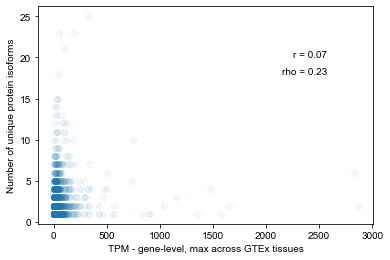

In [253]:
# log-scale?
fig, ax = plt.subplots(1, 1)
x_col = 'TPM - gene-level, max across GTEx tissues'
y_col = 'n_isoforms'
x = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), x_col].values
y = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), y_col].values
ax.scatter(x, y, alpha=0.05)
ax.set_ylabel('Number of unique protein isoforms')
ax.set_xlabel(x_col)
r = stats.pearsonr(x, y)[0]
rho = stats.spearmanr(x, y)[0]
ax.text(x=x.max() * 0.9, y=20, s=f'r = {r:.2f}', ha='right')
ax.text(x=x.max() * 0.9, y=18, s=f'rho = {rho:.2f}', ha='right')

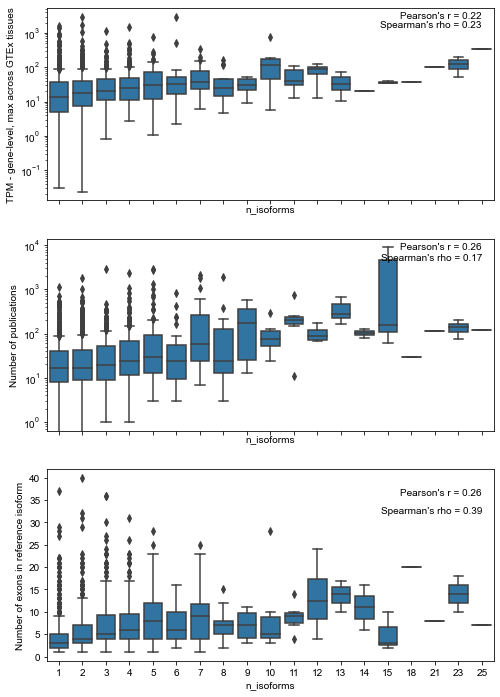

In [279]:
import seaborn as sns

fig, axs = plt.subplots(3, 1, sharex=True)
fig.set_size_inches(w=8, h=12)

y_col = 'n_isoforms'
x = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), x_col].values
y = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), y_col].values

ax = axs[0]
x_col = 'TPM - gene-level, max across GTEx tissues'
sns.boxplot(data=gn, 
               x='n_isoforms', 
               y=x_col,
            ax=ax,
            color='C0')
ax.set_yscale('log')
x = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), x_col].values
y = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), y_col].values
r = stats.pearsonr(np.log2(x + 1), y)[0]
rho = stats.spearmanr(x, y)[0]
ax.text(y=x.max() * 0.9, x=18, s=f'Pearson\'s r = {r:.2f}', ha='right')
ax.text(y=x.max() * 0.5, x=18, s=f'Spearman\'s rho = {rho:.2f}', ha='right')

ax = axs[1]
x_col = 'Number of publications'
sns.boxplot(data=gn, 
               x='n_isoforms', 
               y=x_col,
                ax=ax,
                color='C0')
ax.set_yscale('log')
x = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), x_col].values
y = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), y_col].values
r = stats.pearsonr(np.log2(x + 1), y)[0]
rho = stats.spearmanr(x, y)[0]
ax.text(y=x.max() * 0.9, x=18, s=f'Pearson\'s r = {r:.2f}', ha='right')
ax.text(y=x.max() * 0.5, x=18, s=f'Spearman\'s rho = {rho:.2f}', ha='right')

ax = axs[2]
x_col = 'Number of exons in reference isoform'
sns.boxplot(data=gn,
               x='n_isoforms', 
               y=x_col,
             ax=ax,
             color='C0')
x = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), x_col].values
y = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), y_col].values
r = stats.pearsonr(x, y)[0]
rho = stats.spearmanr(x, y)[0]
ax.text(y=x.max() * 0.9, x=18, s=f'Pearson\'s r = {r:.2f}', ha='right')
ax.text(y=x.max() * 0.8, x=18, s=f'Spearman\'s rho = {rho:.2f}', ha='right')
fig.savefig('../../figures/n-isoforms-vs-expression-publication-n-exons_boxplot.pdf',
            bbox_inches='tight')

NameError: name 'load_tf_families' is not defined

In [15]:
gn['family'].value_counts().head(10)

C2H2 ZF             745
Homeodomain         194
bHLH                108
Unknown              69
bZIP                 54
Forkhead             49
Nuclear receptor     46
HMG/Sox              30
Ets                  27
T-box                17
Name: family, dtype: int64

In [16]:
from data_loading import load_tf_families

fam = load_tf_families()
gn['family'] = gn.index.map(fam)
gn['is_nuclear_receptor'] = (gn['family'] == 'Nuclear receptor')

In [17]:
gn.head()

,"TPM - gene-level, max across GTEx tissues",n_isoforms,Number of publications,Number of exons in reference isoform,family,is_nuclear_receptor
AC008770.3,0.339530,2,NaN,4,C2H2 ZF,False
AC023509.3,4.475325,1,NaN,12,bZIP,False
AC092835.1,0.884619,1,NaN,5,C2H2 ZF,False
AC138696.1,1.760060,1,NaN,1,C2H2 ZF,False
ADNP,9157.752828,3,53.0,3,Homeodomain,False


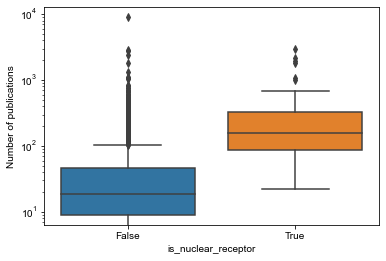

In [19]:
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=gn,
            x='is_nuclear_receptor',
            y='Number of publications',
            ax=ax)
ax.set_yscale('log')

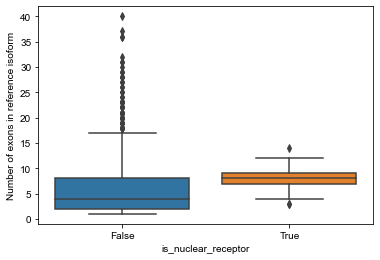

In [21]:
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=gn,
            x='is_nuclear_receptor',
            y='Number of exons in reference isoform',
            ax=ax)

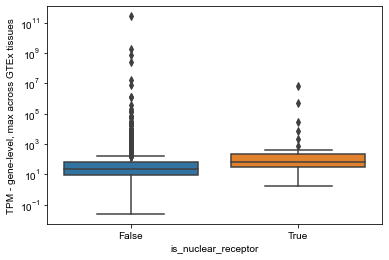

In [23]:
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=gn,
            x='is_nuclear_receptor',
            y='TPM - gene-level, max across GTEx tissues',
            ax=ax)
ax.set_yscale('log')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


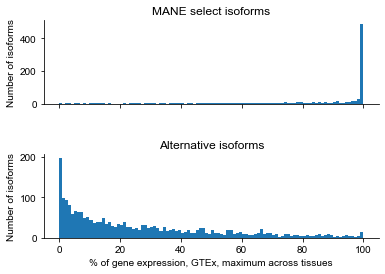

In [7]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins=100
axs[0].hist(f_gtex.max(axis=1).loc[f_gtex.index.isin(ref_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].hist(f_gtex.max(axis=1).loc[f_gtex.index.isin(alt_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].set_xlabel('% of gene expression, GTEx, maximum across tissues')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
plt.subplots_adjust(hspace=0.6)
fig.savefig('../../figures/expression-fraction-GTEx-max-across-tissues_ref-vs-alt_hist.pdf',
            bbox_inches='tight')


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


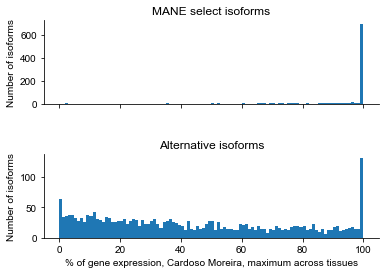

In [8]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= 1)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1

f_dev = f_dev * 100
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins=100
axs[0].hist(f_dev.max(axis=1).loc[f_dev.index.isin(ref_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].hist(f_dev.max(axis=1).loc[f_dev.index.isin(alt_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].set_xlabel('% of gene expression, Cardoso Moreira, maximum across tissues')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
plt.subplots_adjust(hspace=0.6)
fig.savefig('../../figures/expression-fraction-development-max-across-tissues_ref-vs-alt_hist.pdf',
            bbox_inches='tight')


In [17]:
TPM_THRESHOLD = 2
per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= TPM_THRESHOLD)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1
f_dev = f_dev * 100

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= TPM_THRESHOLD).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1
f_gtex = f_gtex * 100

# alternative isoform > 50% in dev with corresponding ref iso > 50% in either
# plus some magnitude of change?
putative_switching_alt_isos = set(f_dev.loc[f_dev.index.isin(alt_isos) &
                                           (f_dev.max(axis=1) > 50), :].index.values)
print(len(putative_switching_alt_isos))
valid_ref_isos = (set(f_dev.loc[f_dev.index.isin(ref_isos) &
                               (f_dev.max(axis=1) > 50), :].index.values)
                        .union(
                  set(f_gtex.loc[f_gtex.index.isin(ref_isos) &
                               (f_gtex.max(axis=1) > 50), :].index.values)
                        ))
if not (genes_gtex == genes_dev).all():
        raise UserWarning()
genes = genes_gtex
genes_with_valid_ref_isos = {genes[iso] for iso in valid_ref_isos}
switching_alt_isos = {iso for iso in putative_switching_alt_isos if genes[iso] in genes_with_valid_ref_isos}
print(len(switching_alt_isos))

729
449


In [111]:
#df_gtex_downsampled = 

# get number of samples of dev then randomly pick gtex to get same number of datapoints and samples 
df_gtex.head()

# loop through gtex tissues
# pick number of samples according to dev dataset
# loop again
# make fake metadata file
n_samples_dev = df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).value_counts().values
np.random.shuffle(n_samples_dev)
gtex_tissues = metadata_gtex['body_site'].value_counts().index.values
import itertools
metadata_gtex_dummy = {}
for i, (n_samples, tissue) in enumerate(zip(n_samples_dev, itertools.cycle(gtex_tissues))):
    metadata_gtex_dummy[tissue + '_' + str(i)] = (metadata_gtex.loc[(metadata_gtex['body_site'] == tissue)
                                                                    & ~metadata_gtex.index.isin({s for samples in metadata_gtex_dummy.values() for s in samples}),
                                                                    :]
                                                        .sample(n_samples).index.values)
metadata_gtex_dummy = (pd.Series({v: k for k, vs in metadata_gtex_dummy.items() for v in vs}, name='body_site')
                         .to_frame())
# TODO: check it is sampling with replacement and ends up same size as dev
if metadata_dev.shape[0] != metadata_gtex_dummy.shape[0]:
    raise UserWarning('Problem with downsampling code')
if sorted(n_samples_dev) != sorted(metadata_gtex_dummy.groupby('body_site').size().values):
    raise UserWarning('Problem with downsampling code')
if metadata_gtex_dummy.index.duplicated().any():
    raise UserWarning('Unexpected duplicates')

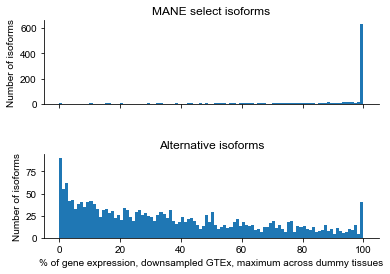

In [114]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins=100
axs[0].hist(f_gtex.max(axis=1).loc[f_gtex.index.isin(ref_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].hist(f_gtex.max(axis=1).loc[f_gtex.index.isin(alt_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].set_xlabel('% of gene expression, downsampled GTEx, maximum across dummy tissues')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
plt.subplots_adjust(hspace=0.6)
fig.savefig('../../figures/expression-fraction-downsampled-GTEx-control-max-across-tissues_ref-vs-alt_hist.pdf',
            bbox_inches='tight')


In [11]:
paired.max()

testis adult    23.861893
Testis          28.142780
dtype: float64

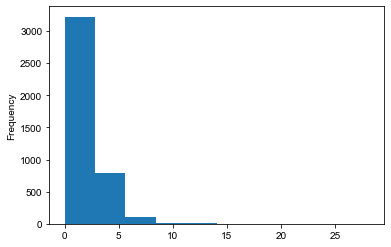

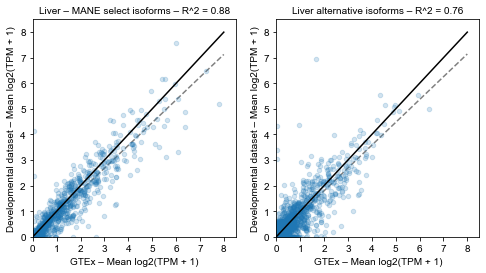

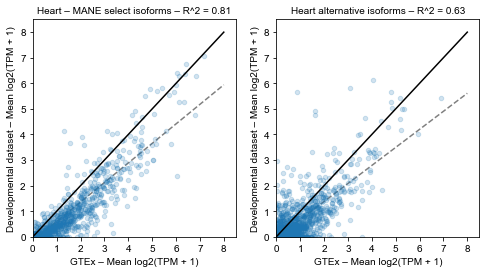

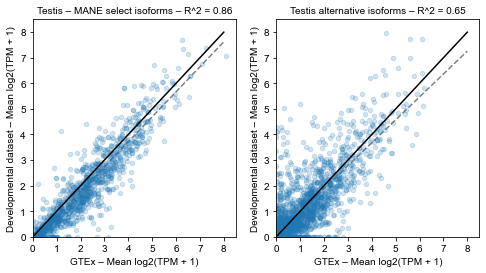

In [20]:
# TODO: diagonal line
# Comparing adult samples between GTEx and develpment
import statsmodels.api as sm
paired_tissues = [('liver adult', 'Liver'),
                  ('heart young adult', 'Heart - Atrial Appendage'),
                  ('testis adult', 'Testis')]
for cm_tissue, gtex_tissue in paired_tissues:
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(w=8, h=4)
    paired = pd.merge(means_dev.loc[:, [cm_tissue]],
                      means_gtex.loc[:, [gtex_tissue]],
            how='inner',
            left_index=True, right_index=True)
    (paired.loc[paired.index.isin(ref_isos), :]
    .plot.scatter(x=gtex_tissue, 
                        y=cm_tissue, 
                        alpha=0.2,
                        ax=axs[0]))
    upper = 8
    #upper = paired.max().max()
    r = paired.loc[paired.index.isin(ref_isos), :].corr().loc[cm_tissue, gtex_tissue]

    x = paired.loc[paired.index.isin(ref_isos), gtex_tissue].values
    y = paired.loc[paired.index.isin(ref_isos), cm_tissue].values
    intercept, slope = sm.OLS(y, sm.add_constant(x)).fit().params
    axs[0].plot(range(upper + 1), [intercept + slope * x for x in range(upper + 1)], '--', color='grey', zorder=-1)

    axs[0].set_title('{} – MANE select isoforms – R^2 = {:.2f}'.format(gtex_tissue.split()[0], r**2),
                    fontsize=10)
    (paired.loc[paired.index.isin(alt_isos), :]
    .plot.scatter(x=gtex_tissue, 
                        y=cm_tissue, 
                        alpha=0.2,
                        ax=axs[1]))
    r = paired.loc[paired.index.isin(alt_isos), :].corr().loc[cm_tissue, gtex_tissue]
    x = paired.loc[paired.index.isin(alt_isos), gtex_tissue].values
    y = paired.loc[paired.index.isin(alt_isos), cm_tissue].values
    intercept, slope = sm.OLS(y, sm.add_constant(x)).fit().params
    axs[1].plot(range(upper + 1), [intercept + slope * x for x in range(upper + 1)], '--', color='grey', zorder=-1)
    axs[1].set_title('{} alternative isoforms – R^2 = {:.2f}'.format(gtex_tissue.split()[0], r**2),
                     fontsize=10)

    for ax in axs:
        ax.set_ylim(0, upper + 0.5)
        ax.set_xlim(0, upper + 0.5)
        ax.set_yticks(range(0, int(upper+1)))
        ax.set_xticks(range(0, int(upper+1)))
        ax.plot([0, upper], [0, upper], '-', color='black')
        ax.set_xlabel('GTEx – Mean log2(TPM + 1)')
        ax.set_ylabel('Developmental dataset – Mean log2(TPM + 1)')
    plt.savefig('../../figures/GTEx-vs-dev_{}_GENCODE.pdf'.format(gtex_tissue), bbox_inches='tight')


In [3]:
# calculate tissue-specificity score for each isoform
def calculate_tiss_spec(x):
    # assumes input of a row of only the tissue expression data
    med = x.median() 
    iqr = x.quantile(0.75) - x.quantile(0.25)
    for tiss in x.index:
        score = (x[tiss] - med) / float(iqr)
        x[tiss] = score
    x['max_tip'] = x.max()
    return x

In [23]:
df.head()

UID,AC006213.1-202_AC006213.1-203_AC006213.1-204_AC006213.1-205,AC008554.1-202,AC008554.1-205,AC008770.2-201,AC008770.2-202,AC073611.1-201_AC073611.1-202,AC073611.1-203,AC092072.1-202,AC092072.1-203,AC092835.1-201,AC118549.1-202,AC118549.1-204,AC138696.1-201,AC139768.1-204,AC139768.1-205,ADNP-201_ADNP-202_ADNP-203_ADNP-204_ADNP-205,ADNP-207,ADNP-208,ADNP2-201,AEBP1-201,AEBP1-206,AEBP2-201,AEBP2-202,AEBP2-204,AEBP2-207,AHCTF1-201,AHCTF1-202,AHCTF1-207,AHDC1-201_AHDC1-202_AHDC1-206_AHDC1-207_AHDC1-213,AHR-201,AHR-206,AHRR-202,AHRR-208,AHRR-209,AIRE-201,AKAP8-201,AKAP8L-201,AKAP8L-208,AKNA-201,AKNA-202_AKNA-206,AKNA-203,AKNA-204,AKNA-205,AL590327.1-201_AL590327.1-202,ALX1-201,ALX3-201_ALX3-202,ALX3-203,ALX4-201_ALX4-202,ANHX-201_ANHX-202,ANKZF1-201_ANKZF1-203,...,ZSCAN2-213,ZSCAN20-201,ZSCAN20-202,ZSCAN21-201,ZSCAN21-203,ZSCAN21-205,ZSCAN22-201,ZSCAN23-201,ZSCAN25-201,ZSCAN25-202_ZSCAN25-204,ZSCAN26-201_ZSCAN26-204,ZSCAN26-202_ZSCAN26-206,ZSCAN26-203,ZSCAN26-207,ZSCAN29-201,ZSCAN29-202,ZSCAN29-204,ZSCAN29-207,ZSCAN30-201_ZSCAN30-202,ZSCAN30-205,ZSCAN30-208,ZSCAN30-210,ZSCAN30-211,ZSCAN30-212,ZSCAN31-201_ZSCAN31-202_ZSCAN31-203_ZSCAN31-209,ZSCAN31-214_ZSCAN31-219,ZSCAN32-201,ZSCAN32-202,ZSCAN32-203,ZSCAN32-204,ZSCAN32-205_ZSCAN32-214,ZSCAN32-209,ZSCAN32-211,ZSCAN4-201_ZSCAN4-202,ZSCAN5A-201_ZSCAN5A-205,ZSCAN5A-206,ZSCAN5A-214,ZSCAN5B-201_ZSCAN5B-202,ZSCAN5C-201_ZSCAN5C-202,ZSCAN9-201_ZSCAN9-207,ZSCAN9-202,ZSCAN9-204,ZSCAN9-208,ZUP1-201,ZUP1-202,ZXDA-201,ZXDB-201,ZXDC-201,ZXDC-202,body_site
SRR1489648,1.116706,1.546887,1.386965,0.0,0.000000,0.000000,0.0,1.679307,0.000000,0.417390,2.755400,2.940774,0.490392,3.408776,1.767350,7.645911,1.320358,1.399685,2.993310,6.980825,5.904735,3.037514,3.590494,0.541054,7.053697e-09,3.716365,2.394369e-08,2.263996,7.143560,4.501707,0.000000,0.000000,0.0,0.291965,0.796005,4.093247,5.541310,9.461581e-07,2.723578,6.201540,1.431216,0.000331,3.754150,1.194677,0.055703,1.824194,0.000000,0.058400,0.000000,8.272940,...,0.414804,0.986695,0.208431,2.981845,1.482972,0.000000e+00,1.584260,0.431333,0.000000,2.146267,1.298406,4.001793,1.286840,2.358016,0.0,2.672378,0.0,0.315965,0.670662,2.131461,0.518671,0.0,2.946849,0.776376,2.750369,1.205599,1.029043,0.269392,1.436471,0.000000,1.535033,0.0,0.654816,0.677058,0.603731,0.418870,0.615599,0.173437,0.190877,3.953846,1.818740,1.715125,0.0,0.349067,3.293604,1.852235,2.118496,1.698690,2.604195,Adipose - Visceral (Omentum)
SRR1414332,1.245530,2.025599,1.546541,0.0,0.308667,0.000000,0.0,2.441199,0.775009,0.395550,2.735737,2.349832,0.939258,3.299154,1.366834,9.795767,2.608286,0.731845,3.641696,4.774729,4.347659,2.568412,3.191155,0.000000,0.000000e+00,3.001183,2.256215e-06,1.976081,9.257512,2.470001,0.102833,0.273244,0.0,0.000000,0.969001,4.020600,6.094029,0.000000e+00,1.118087,3.769481,0.989896,0.021274,3.009037,3.809838,0.653062,2.195574,0.677495,0.050372,0.000000,10.065063,...,0.000000,0.944258,0.199654,3.731791,0.731977,0.000000e+00,1.518142,0.501887,0.000000,4.870622,3.559681,3.051509,2.585508,2.372855,0.0,3.315604,0.0,0.000000,0.731263,2.607610,0.681390,0.0,3.510190,1.312444,1.534125,0.656948,2.693188,1.340824,0.011164,1.521985,2.124709,0.0,1.944933,0.656519,1.776169,1.529296,0.544535,0.085822,0.141220,4.647761,1.869745,2.076378,0.0,0.342359,2.960124,1.604598,2.324888,1.027996,3.081832,Prostate
SRR615886,2.396149,3.356542,1.544975,0.0,0.000000,0.762762,0.0,2.499509,0.611019,0.509324,3.509987,3.014107,0.977855,3.472878,1.162461,12.350504,2.398454,0.761560,3.579747,5.559452,4.955043,2.973813,3.297745,0.555932,0.000000e+00,4.058022,4.413601e-06,1.028760,10.350207,4.391541,0.212427,0.073257,0.0,0.000000,1.077038,3.760370,5.526889,0.000000e+00,0.735338,4.533253,0.887571,0.000000,2.886423,2.627138,0.157916,2.041313,1.159339,0.341248,0.000000,8.754351,...,0.000000,1.191657,0.353210,3.352821,1.001550,3.165772e-05,2.044051,1.146531,0.000000,4.977576,2.716504,3.053050,3.053376,2.772481,0.0,3.567874,0.0,0.000000,0.449318,3.301948,0.929337,0.0,4.211542,1.691556,6.643892,1.601834,

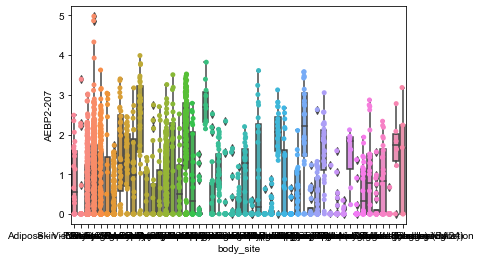

In [26]:
# dot / box plot
df = df_gtex.T.copy()
isoform = 'AEBP2-207'
df['body_site'] = df.index.map(metadata_gtex['body_site'])
sns.boxplot(data=df, x='body_site', y=isoform)
sns.stripplot(data=df, x='body_site', y=isoform)

In [4]:
# Calculate tissue-specificity score for Lambert TFs in GTEx
# Both at isoform and gene level
fn = '/Users/gloriasheynkman/Documents/research_drive/files_ccsb/project_tf_isoforms/iso_master/analysis2/17_tiss_expression/a_lambert_tfs_gtex_iso_medians.tsv'
# load gtex data, median for each isoform
gt = pd.read_table(fn)

In [5]:
gt.head()

,gene,isoname,appris_rank,adipose,adrenal_gland,artery,bladder,brain,breast,cells,...,prostate,skin,small_intestine,spleen,stomach,testis,thyroid,uterus,vagina,whole_blood
0,SP7,AC073611.1-202,1,0.038176,0.000000,0.000000,0.000000,0.090045,0.019499,0.000000,...,0.000000,0.015181,0.000000,0.018288,0.000000,0.713944,0.171921,0.020367,0.000000,0.000000
1,ZUFSP,ZUP1-202,1,4.180283,4.010178,3.337592,4.349150,3.698786,4.372231,6.445111,...,3.396159,4.689506,5.149393,4.746341,3.526572,5.486379,3.868057,3.503805,4.314425,1.336929
2,ZUFSP,ZUP1-201,2,0.000000,0.000000,0.000000,0.309656,0.000000,0.000000,0.150548,...,0.000000,0.358577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,PHF19,PHF19-202,1,9.336834,7.603093,19.328497,17.142679,8.008652,8.989591,11.639142,...,14.153244,5.634106,9.965369,12.943445,5.572975,10.434237,6.834339,20.022945,13.739438,7.216362
4,PHF19,PHF19-201,2,0.231737,0.923771,0.707472,0.216458,0.282654,0.217751,6.301599,...,0.561690,0.441973,0.670927,2.293726,0.423691,0.000000,0.222796,0.462285,0.710689,2.389527


In [27]:
# gene-level data
gtg = gt.drop(columns=['isoname', 'appris_rank'])
gtg = gtg.groupby('gene').sum()
# gtex gene-level scores
gtgs = gtg.apply(calculate_tiss_spec, axis=1)
gtgs.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


,adipose,adrenal_gland,artery,bladder,brain,breast,cells,cervix,colon,esophagus,...,skin,small_intestine,spleen,stomach,testis,thyroid,uterus,vagina,whole_blood,max_tip
gene,,,,,,,,,,,,,,,,,,,,,
AC023509.3,0.656770,0.028875,1.584656,0.197346,-0.683648,0.307462,5.266614,-0.174727,0.000000,0.570192,...,-0.332915,-0.490098,-1.308971,-0.678265,-0.757402,-0.298023,0.729773,0.201063,-1.390636,5.266614
AC092835.1,0.000000,0.000000,0.000000,2.169659,0.000000,0.000000,1.793892,2.380971,0.888812,1.205127,...,0.000000,0.000000,0.000000,0.000000,2.598186,0.999685,2.143781,0.459106,0.000000,2.598186
ADNP,-0.832970,0.323038,0.491102,-0.020149,0.107396,-0.629756,-2.255214,0.284810,0.534387,0.361090,...,0.000000,0.449866,2.090081,0.252264,2.818305,-0.239327,0.498836,-0.252542,-1.573869,2.818305
ADNP2,0.508389,-0.534602,-0.157302,0.943831,-1.532543,0.645315,0.566064,-0.196187,-0.183818,0.173201,...,2.090451,0.000000,-0.455906,-0.350386,4.978282,0.188759,-0.394874,0.146169,-2.674572,4.978282
AEBP1,0.873514,-0.196716,6.940975,0.662797,-0.510048,0.746549,-0.251459,2.132590,0.109833,0.000000,...,0.019151,-0.064640,-0.148331,-0.280085,-0.177429,0.100873,1.700510,1.374710,-0.587561,6.940975


In [28]:
# isoform-level data
gti = gt.set_index(['gene', 'isoname', 'appris_rank'])
# gtex isoform-level scores
gtis = gti.apply(calculate_tiss_spec, axis=1)
gtis.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


adipose  adrenal_gland    artery  \
gene   isoname        appris_rank                                      
SP7    AC073611.1-202 1            1.915216       0.000000  0.000000   
ZUFSP  ZUP1-202       1            0.285508       0.114344 -0.562428   
       ZUP1-201       2                 NaN            NaN       NaN   
PHF19  PHF19-202      1           -0.112808      -0.291029  0.914290   
       PHF19-201      2           -0.468616       0.938025  0.498372   

                                    bladder     brain    breast      cells  \
gene   isoname        appris_rank                                            
SP7    AC073611.1-202 1            0.000000  4.517383  0.978227   0.000000   
ZUFSP  ZUP1-202       1            0.455426 -0.198986  0.478650   2.564432   
       ZUP1-201       2                 inf       NaN       NaN        inf   
PHF19  PHF19-202      1            0.689598 -0.249339 -0.148503   0.123859   
       PHF19-201      2           -0.499672 -0.365121 -0.497045  11.869096   

                                     cervix     colon  esophagus  ...  \
gene   isoname        appris_rank                                 ...   
SP7    AC073611.1-202 1            0.973963  0.000000   0.000000  ...   
ZUFSP  ZUP1-202       1            0.049299 -0.092795   0.099225  ...   
       ZUP1-201       2                 NaN       NaN        NaN  ...   
PHF19  PHF19-202      1            0.703410  0.374452   0.755212  ...   
       PHF19-201      2            0.659615  0.130872   1.362221  ...   

                                       skin  small_intestine    spleen  \
gene   isoname        appris_rank                                        
SP7    AC073611.1-202 1            0.761601         0.000000  0.917448   
ZUFSP  ZUP1-202       1            0.797900         1.260650  0.855089   
       ZUP1-201       2                 inf              NaN       NaN   
PHF19  PHF19-202      1           -0.493432        -0.048197  0.257935   
       PHF19-201      2           -0.041287         0.424090  3.722620   

                                    stomach     testis   thyroid    uterus  \
gene   isoname        appris_rank                                            
SP7    AC073611.1-202 1            0.000000  35.817213  8.624944  1.021773   
ZUFSP  ZUP1-202       1           -0.372272   1.599733 -0.028661 -0.395180   
       ZUP1-201       2                 NaN        NaN       NaN       NaN   
PHF19  PHF19-202      1           -0.499716   0.000000 -0.370053  0.985676   
       PHF19-201      2           -0.078447  -0.939649 -0.486790  0.000000   

                                     vagina  whole_blood    max_tip  
gene   isoname        appris_rank                                    
SP7    AC073611.1-202 1            0.000000     0.000000  35.817213  
ZUFSP  ZUP1-202       1            0.420485    -2.575543   2.564432  
       ZUP1-201       2                 NaN          NaN        inf  
PHF19  PHF19-202      1            0.339760    -0.330783   0.985676  
       PHF19-201      2            0.504911     3.917348  11.869096  

[5 rows x 32 columns]

In [29]:
# combine gene and isoform-level data into a isoform-specific tissue-specificity score
# gtex isoform and gene scores
gtigs = pd.merge(gtis.reset_index(), gtgs.reset_index(), how='left', on='gene', suffixes=['_iso', '_gene']) 
gtigs = gtigs[['gene', 'isoname', 'appris_rank', 'max_tip_iso', 'max_tip_gene']]
gtigs['iso_spec_tip'] = gtigs['max_tip_iso'] / gtigs['max_tip_gene']
gtigs.head()

,gene,isoname,appris_rank,max_tip_iso,max_tip_gene,iso_spec_tip
0,SP7,AC073611.1-202,1,35.817213,35.817213,1.000000
1,ZUFSP,ZUP1-202,1,2.564432,2.598899,0.986738
2,ZUFSP,ZUP1-201,2,inf,2.598899,inf
3,PHF19,PHF19-202,1,0.985676,0.901533,1.093333
4,PHF19,PHF19-201,2,11.869096,0.901533,13.165455


In [30]:
# distribution of iso and gene tip scores

Text(0, 0.5, 'TiP isoform score (max across GTEx tissues)')

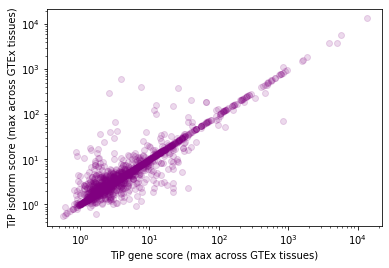

In [31]:
# compare gene-level and isoform-level tip scores
fig, ax = plt.subplots()
plt.scatter(gtigs['max_tip_gene'], gtigs['max_tip_iso'], alpha=0.15, color='purple')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('TiP gene score (max across GTEx tissues)')
plt.ylabel('TiP isoform score (max across GTEx tissues)')

Text(0, 0.5, 'Count')

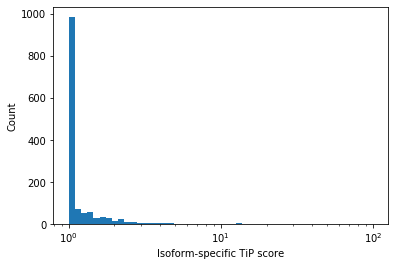

In [32]:
# what is the distribution of isoform-specific tip score
# remove nan and inf values
gtigs2 = gtigs.replace([np.inf, -np.inf], np.nan)
MIN = 1
MAX = 100
plt.hist(gtigs2['iso_spec_tip'], bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 50))
plt.xscale('log')
plt.xlabel('Isoform-specific TiP score')
plt.ylabel('Count')
# plt.ylim(0,100)

Text(0, 0.5, 'Count')

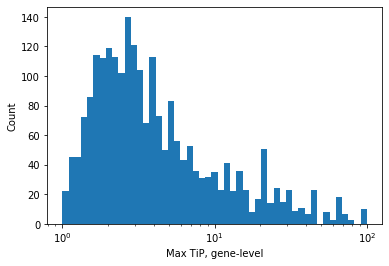

In [33]:
# distribution of gene-level tip scores
MIN = 1
MAX = 100
plt.hist(gtigs2['max_tip_gene'], bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 50))
plt.xscale('log')
plt.xlabel('Max TiP, gene-level')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

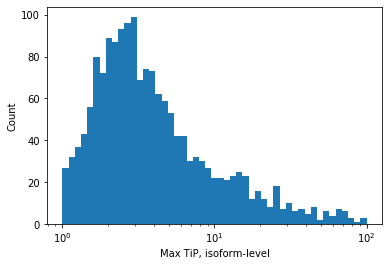

In [34]:
# distribution of iso-level tip scores
MIN = 1
MAX = 100
plt.hist(gtigs2['max_tip_iso'], bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 50))
plt.xscale('log')
plt.xlabel('Max TiP, isoform-level')
plt.ylabel('Count')

In [6]:
data = load_rna_expression_data()
tfs = tfs.drop(columns=['tpm_stdev'])

writing out


NameError: name 'tfs' is not defined

In [ ]:
tfs = tfs.set_index(['gene', 'isoacc', 'tiss'])
tfs = tfs.unstack(level='tiss')
tfs.columns = tfs.columns.get_level_values(1)
tfs['median'] = tfs.median(axis=1)
tfs['iqr'] = tfs.quantile(0.75, axis=1) - tfs.quantile(0.25, axis=1)

In [ ]:
# calculate tissue-specificity score for each isoform
def calculate_tiss_spec(x):
    med = x['median']
    iqr = x['iqr']
    for tiss in x.index[:-2]:
        score = (x[tiss] - med) / float(iqr)
        x[tiss] = score
    return x
tfs.apply(calculate_tiss_spec, axis=1)

In [ ]:
tfs.head()

In [ ]:
tfs.to_csv('expr_data_tiss_scores.tsv', sep='\t')